In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad, jacfwd, jacrev
from jax.scipy.optimize import minimize

key = random.PRNGKey(42)

from jax.config import config
config.update("jax_enable_x64", True)

# 2-qubit random unitary

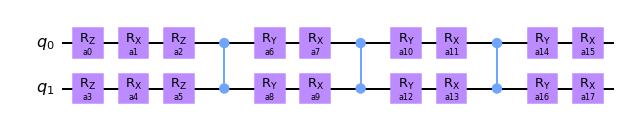

In [2]:
num_qubits = 2
depth = theoretical_lower_bound(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
u_target = unitary_group.rvs(2**num_qubits, random_state=1)
anz_cost = lambda angs : disc2(anz.unitary(angs), u_target)


initial_angles = random_angles(anz.num_angles, key=random.PRNGKey(101))

anz.circuit().draw(output='mpl')

In [3]:
%%time
angles_history_gd, loss_history_gd = gradient_descent_minimize(anz_cost, 
                                                               anz.num_angles, 
                                                               learning_rate=0.1,
                                                               initial_params=initial_angles)

CPU times: user 4.69 s, sys: 185 ms, total: 4.87 s
Wall time: 4.36 s


In [4]:
%%time
preconditioner = plain_natural_preconditioner(anz.unitary)
angles_history_natural, loss_history_natural = gradient_descent_minimize(anz_cost, 
                                                                         anz.num_angles, 
                                                                         initial_params=initial_angles,
                                                                         preconditioner_func=preconditioner,  
                                                                         learning_rate=0.1)

CPU times: user 4.43 s, sys: 88.9 ms, total: 4.52 s
Wall time: 4.44 s


In [5]:
%%time
preconditioner = plain_hessian_preconditioner(anz_cost)
angles_history_plain, loss_history_plain = gradient_descent_minimize(anz_cost, 
                                                                     anz.num_angles, 
                                                                     initial_params=initial_angles,
                                                                     preconditioner_func=preconditioner,
                                                                     learning_rate=0.1)

CPU times: user 26.8 s, sys: 11.8 s, total: 38.6 s
Wall time: 17.5 s


In [6]:
%%time
preconditioner = sparse_hessian_preconditioner(anz_cost)
angles_history_sparse, loss_history_sparse = gradient_descent_minimize(anz_cost, 
                                                                       anz.num_angles, 
                                                                       initial_params=initial_angles,
                                                                       preconditioner_func=preconditioner,
                                                                       learning_rate=0.1)

CPU times: user 20.1 s, sys: 272 ms, total: 20.4 s
Wall time: 18.8 s


In [7]:
angles_history_adam, loss_history_adam = anz.learn(u_target, 
                                                   initial_params=initial_angles,
                                                   learning_rate=0.1)

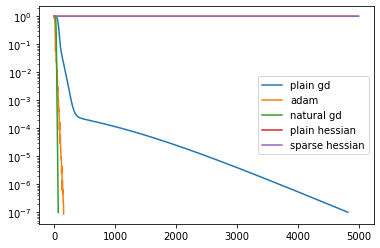

In [8]:
plt.plot(loss_history_gd, label='plain gd')
plt.plot(loss_history_adam, label='adam')
plt.plot(loss_history_natural, label='natural gd')
plt.plot(loss_history_plain, label='plain hessian')
plt.plot(loss_history_sparse, label='sparse hessian')
plt.legend()
plt.yscale('log')

## Check of Fubini-Study metric

Overall things look good, but the second term in the fubini-study metric appear to be of little effect, which is a bit puzzling.

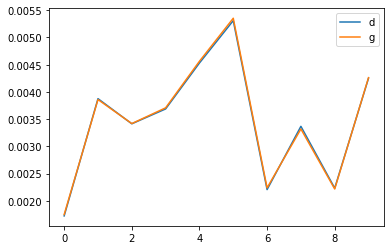

In [5]:
angles = random_angles(anz.num_angles, key=random.PRNGKey(113))
u_norm = jnp.abs(trace_prod(anz.unitary(angles),anz.unitary(angles)))


distances = []
metric_distances = []

for k in range(10):
    d_angles = 1e-2*random_angles(anz.num_angles, key=random.PRNGKey(k))
    dist = jnp.arccos(jnp.abs(trace_prod(anz.unitary(angles), anz.unitary(angles+d_angles))/u_norm))
    dist2 = dist**2
    
    g_metric = fubini_study(anz.unitary, angles, relative_coeff=1)
    quad2 = d_angles@g_metric@d_angles
    distances.append(dist2)
    metric_distances.append(quad2)

plt.plot(distances, label='d')
plt.plot(metric_distances, label='g')
plt.legend()

# 3-qubit Toffoli

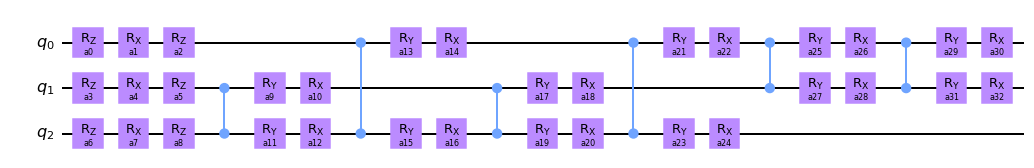

In [9]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cz', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

In [10]:
cost_toff3 = lambda angs: disc2(anz_toff3.unitary(angs), u_toff3)
# Interesting values: k=13 adam wins, k=23 nadam wins, at k=33 ngd wins, LOL. Is it a joke or something?
initial_angles = random_angles(anz_toff3.num_angles, key=random.PRNGKey(43))

In [11]:
%%time
preconditioner=plain_natural_preconditioner(anz_toff3.unitary)
angles_history_nadam, loss_history_nadam = optax_minimize(cost_toff3,
                                                      anz_toff3.num_angles,
                                                      optax.adam(0.1),
                                                      preconditioner_func=preconditioner,
                                                      initial_params=initial_angles,
                                                      num_iterations=1000) 

CPU times: user 15.7 s, sys: 2.82 s, total: 18.5 s
Wall time: 12.4 s


In [12]:
%%time
angles_history_adam, loss_history_adam = anz_toff3.learn(u_toff3, 
                                                         initial_params=initial_angles, 
                                                         num_iterations=1000)

CPU times: user 6.29 s, sys: 119 ms, total: 6.41 s
Wall time: 6.11 s


In [13]:
%%time
preconditioner = plain_natural_preconditioner(anz_toff3.unitary)
angles_history_ngd, loss_history_ngd = gradient_descent_minimize(cost_toff3,
                                                                 anz_toff3.num_angles,
                                                                 preconditioner_func=preconditioner,
                                                                 learning_rate=0.1,
                                                                 initial_params=initial_angles,
                                                                 num_iterations=1000) 

CPU times: user 17 s, sys: 2.11 s, total: 19.1 s
Wall time: 14.6 s


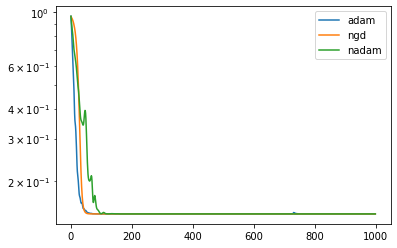

In [14]:
plt.plot(loss_history_adam, label='adam')
plt.plot(loss_history_ngd, label='ngd')
plt.plot(loss_history_nadam, label='nadam')
plt.legend()
plt.yscale('log')

Finishing learning with hessian proves that the optimum is very robust.

In [60]:
%%time
preconditioner = plain_hessian_preconditioner(cost_toff3)
angles_history_hessian, loss_history_hessian = gradient_descent_minimize(cost_toff3,
                                                                         anz_toff3.num_angles, 
                                                                         preconditioner_func=preconditioner,
                                                                         initial_params=angles_history_adam[-1])                                                            

CPU times: user 1min 25s, sys: 28.4 s, total: 1min 53s
Wall time: 57.3 s


In [63]:
grad(cost_toff3)(angles_history_hessian[-1])

DeviceArray([-3.33066907e-16,  2.22044605e-16, -9.09396428e-17,
              1.66533454e-16, -3.81232123e-17,  1.66533454e-16,
              3.78354875e-16, -2.77555756e-16, -3.33066907e-16,
              1.37261854e-16, -5.22650714e-17, -5.55111512e-17,
              2.77555756e-16,  1.44328993e-15, -1.24416010e-16,
             -1.66533454e-16,  1.38777878e-16,  2.74523708e-16,
              1.37261854e-16,  3.33066907e-16,  1.51981471e-16,
             -4.44089210e-16, -2.77555756e-16,  0.00000000e+00,
              1.66533454e-16, -1.11022302e-16,  3.33066907e-16,
             -1.07757661e-31, -5.22652875e-17,  2.22044605e-16,
             -9.71445147e-17, -5.22589366e-17, -2.41791330e-16],            dtype=float64)

# Quadratic form

In [2]:
n = 3
A = random.normal(random.PRNGKey(0), (n,n))
A = A + A.T

x = random.normal(random.PRNGKey(1), (n,))
y = random.normal(random.PRNGKey(1), (n,))

def quad(x, y):
    return x@A@y

print(jacfwd(grad(quad, argnums=0), argnums=1)(x,x))
print(A)

# vmap(grad)(grad(quad, argnums=(0)))

# vmap(lambda f: grad(f, argnums=(1,))(x, y))(grad(quad, argnums=(0,)))

[[-0.744222   -0.47258872 -0.8538813 ]
 [-0.47258872  0.899473   -0.7430085 ]
 [-0.8538813  -0.7430085   1.4633775 ]]
[[-0.744222   -0.47258872 -0.8538813 ]
 [-0.47258872  0.899473   -0.7430085 ]
 [-0.8538813  -0.7430085   1.4633775 ]]


# Simple function

In [32]:
def test_f(x):
    return (jnp.sin(x)**2+x**4-x**2+10*x).sum()

n_x = 100
test_primals = random.normal(random.PRNGKey(0), (n_x, ))
test_tangets = random.normal(random.PRNGKey(1), (n_x, ))

In [33]:
%%time
plain_hessian = plain_hessian_preconditioner(test_f, learning_rate=0.01)
angles_history_plain, loss_history_plain = gradient_descent_minimize(test_f, n_x, plain_hessian)

CPU times: user 6.01 s, sys: 2.41 s, total: 8.42 s
Wall time: 2.59 s


In [34]:
%%time
sparse_hessian = hessian_preconditioner(test_f, learning_rate=0.01)
angles_history_sparse, loss_history_sparse = gradient_descent_minimize(test_f, n_x, sparse_hessian)

CPU times: user 1.11 s, sys: 67.3 ms, total: 1.18 s
Wall time: 1.02 s


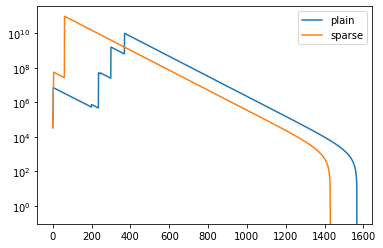

In [35]:
plt.plot(loss_history_plain, label='plain')
plt.plot(loss_history_sparse, label='sparse')
plt.legend()
plt.yscale('log')